<h1 style="margin-bottom: 5px;">Proyecto final - Brain Tumor MRI Challenge</h1>
<h2 style="margin-bottom: 10px;">Introducción a Los Sistemas Inteligentes – 2025-1</h2>

<p>
Fabian Leandro Lopez Gomez - flopezgo@unal.edu.co<br>
Gabriel Alejandro Londono Tobon - glondonot@unal.edu.co<br>
Haider Andres Mayorga Vela - hmayorgav@unal.edu.co
</p>

# A. Descripción del problema

El diagnóstico por resonancia magnética (MRI) del cerebro es rutinario, pero
interpretar cientos de cortes por paciente exige tiempo y especialistas.
Automatizar la **clasificación de tumores cerebrales (glioma, meningioma, pituitario) + ausencia de tumor**  reduce carga clínica y puede acelerar decisiones terapéuticas en zonas con pocos neurorradiólogos

Un error de clasificación (falso positivo o negativo) tiene consecuencias
críticas, por eso la competencia evalúa una **métrica compuesta**:

$$ \text{Score final} = \text{Recall_macro} + \text{Accuracy} $$

* **Recall macro** – promedia la sensibilidad de cada clase, forzando un balance
  en datasets desbalanceados.  
* **Accuracy** – porcentaje global de aciertos

Nuestro objetivo es entrenar, afinar y explicar un clasificador profundo que
maximize dicha métrica, compararlo luego con un LLM multimodal y generar un
`submissionModel.csv` para Kaggle.




---

# B. Importación de datos

In [ ]:
# ⬇️ 1) Instalación de dependencias (solo la 1.ª vez)
!pip -q install kaggle albumentations==1.4.6 timm==0.9.12 torchmetrics==1.3.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.4 MB/s eta 0:00:00
Reason for being yanked: <none given>
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.5/153.5 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 46.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 41.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 95.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 68.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━

In [ ]:
# 1. Sube el archivo kaggle.json
from google.colab import files
files.upload()  # selecciona el archivo kaggle.json

# 2. Mueve el archivo al directorio correcto
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

# 3. Cambia los permisos para mayor seguridad
!chmod 600 ~/.kaggle/kaggle.json

# 4. Descarga la competencia
!kaggle competitions download -c proyecto-final-iis-2025-1-unal




Saving kaggle.json to kaggle.json
 99% 414M/416M [00:02<00:00, 145MB/s]
100% 416M/416M [00:02<00:00, 154MB/s]


In [ ]:
!unzip proyecto-final-iis-2025-1-unal.zip -d ./proyecto-final/

Streaming output truncated to the last 5000 lines.
  inflating: ./proyecto-final/ISI_dataset/train/img0720.jpg  
  inflating: ./proyecto-final/ISI_dataset/train/img0721.jpg  
  inflating: ./proyecto-final/ISI_dataset/train/img0722.jpg  
  inflating: ./proyecto-final/ISI_dataset/train/img0723.jpg  
  inflating: ./proyecto-final/ISI_dataset/train/img0724.jpg  
  inflating: ./proyecto-final/ISI_dataset/train/img0725.jpg  
  inflating: ./proyecto-final/ISI_dataset/train/img0726.jpg  
  inflating: ./proyecto-final/ISI_dataset/train/img0727.jpg  
  inflating: ./proyecto-final/ISI_dataset/train/img0728.jpg  
  inflating: ./proyecto-final/ISI_dataset/train/img0729.jpg  
  inflating: ./proyecto-final/ISI_dataset/train/img0730.jpg  
  inflating: ./proyecto-final/ISI_dataset/train/img0731.jpg  
  inflating: ./proyecto-final/ISI_dataset/train/img0732.jpg  
  inflating: ./proyecto-final/ISI_dataset/train/img0733.jpg  
  inflating: ./proyecto-final/ISI_dataset/train/img0734.jpg  
  inflating: ./proy

In [ ]:
# # ⬇️ 4) Descargar y descomprimir la competencia
# COMP_TAG = 't-2c8c60c70ec72653cd44d53217feaadd'  # TOKEN de enlace privado
# !kaggle competitions download -c $COMP_TAG -p data
# !unzip -q data/*.zip -d data

# ⬇️ 5) Cargar CSV de etiquetas
import pandas as pd
labels_df = pd.read_csv('/content/drive/MyDrive/DATAProyectoISI/ISI_dataset/train_labels.csv')
labels_df.head()

,id,label
0,img0001.jpg,meningioma
1,img0002.jpg,glioma
2,img0003.jpg,pituitary
3,img0004.jpg,glioma
4,img0005.jpg,pituitary


# C. Exploración de datos

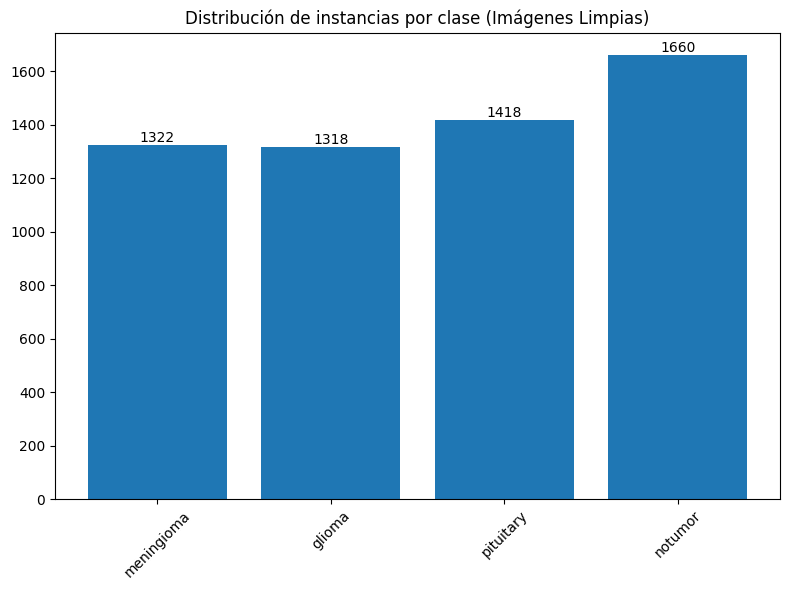

Tamaño medio (W×H): 446.6 × 448.9
Tamaño mínimo (W×H): 150 × 168
Tamaño máximo (W×H): 1920 × 1080
Desviación estándar (W×H): 133.7 × 125.3
Rango (W×H): 1770 × 912


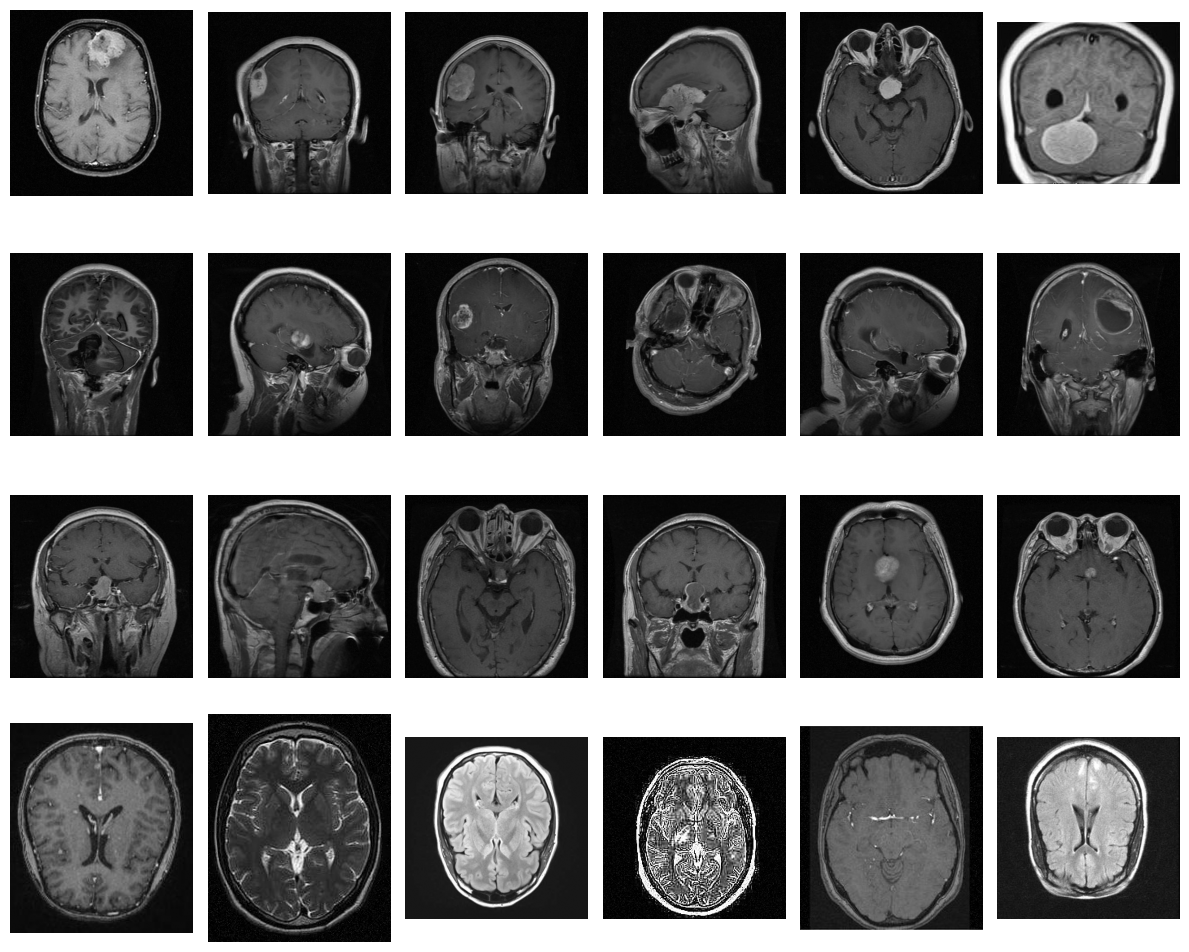

Imágenes corruptas: 0


In [ ]:
import matplotlib.pyplot as plt
from collections import Counter
from glob import glob
from PIL import Image
import numpy as np

# Ruta Drive
DRIVE_BASE_DIR = '/content/drive/MyDrive/DATAProyectoISI'
TRAIN_DIR = '/content/drive/MyDrive/DATAProyectoISI/ISI_dataset/train'


# 1) Distribución de clases
class_counts = Counter(labels_df['label'])

# Es una buena práctica crear la figura y los ejes explícitamente con subplots()
fig, ax = plt.subplots(figsize=(8, 6))

# Crear las barras usando el objeto de ejes 'ax'
bars = ax.bar(list(class_counts.keys()), list(class_counts.values()))

# --- LA LÍNEA CLAVE ---
# Añade las etiquetas de número directamente sobre cada barra.
# fmt='%d' asegura que se muestre como un número entero.
ax.bar_label(bars, fmt='%d')

# Configurar el resto del gráfico
ax.set_title('Distribución de instancias por clase (Imágenes Limpias)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2) Tamaños de imágenes
paths = glob(f'{TRAIN_DIR}/*.jpg')[:2000]
sizes = [Image.open(p).size for p in paths]

if sizes:
    widths, heights = zip(*sizes)
    print(f'Tamaño medio (W×H): {np.mean(widths):.1f} × {np.mean(heights):.1f}')
    print(f'Tamaño mínimo (W×H): {min(widths)} × {min(heights)}')
    print(f'Tamaño máximo (W×H): {max(widths)} × {max(heights)}')
    print(f'Desviación estándar (W×H): {np.std(widths):.1f} × {np.std(heights):.1f}')
    print(f'Rango (W×H): {max(widths)-min(widths)} × {max(heights)-min(heights)}')

else:
    print('⚠️ No hay archivos JPG en:', TRAIN_DIR)

# 3) Visualizar Galería de ejemplos por clase (hasta 6 c/u)
classes = list(class_counts.keys())  # detecta ['glioma','meningioma','pituitario','no tumor'] en CSV

fig, axes = plt.subplots(len(classes), 6, figsize=(12, 2.5*len(classes)))
for row, cls in enumerate(classes):
    df_cls = labels_df[labels_df['label'] == cls]
    n_samples = min(6, len(df_cls))
    sample_ids = df_cls.sample(n_samples, random_state=0)['id']

    for col in range(6):
        ax = axes[row, col]
        if col < n_samples:
            img_id = sample_ids.iloc[col]
            img = Image.open(f'{TRAIN_DIR}/{img_id}')
            ax.imshow(img, cmap='gray')
        ax.axis('off')

        if col == 0:
            ax.set_ylabel(cls, rotation=0, labelpad=40, va='center', fontsize=12)

plt.tight_layout()
plt.show()

# 4) Comprobar imágenes corruptas
bad = []
for p in glob(f'{TRAIN_DIR}/*.jpg'):
    try:
        Image.open(p).verify()
    except Exception:
        bad.append(p)
print('Imágenes corruptas:', len(bad))



***

## Filtro de Imágenes No Aptas

En este bloque de código se recorre cada imagen del directorio de entrenamiento y se aplica una **triple validación** para asegurar una calidad mínima de los datos antes del preprocesamiento:

---

### 1. Detección de imágenes “totalmente negras”
- Se carga la imagen en escala de grises y se calcula la intensidad media de sus píxeles.
- Si la media es menor o igual a un umbral (`BLACK_MEAN_THRESHOLD`), la imagen carece de contenido útil (o está mal capturada) y se marca para descartar.

---

### 2. Detección de imágenes “demasiado pequeñas”
- Se revisan las dimensiones en píxeles (alto y ancho) de la imagen.
- Si alguna de las dimensiones es menor a un umbral (`MIN_DIMENSION_THRESHOLD`), la imagen se descarta. Esto es crucial porque una resolución muy baja impide un análisis fiable por parte del modelo, sin importar la nitidez o el contraste.

---

### 3. Detección de imágenes con “bajo contraste”
- Este criterio reemplaza la simple detección de "borrosidad", ya que es un indicador de calidad más fiable para imágenes de Resonancia Magnética.
- Se analiza el histograma de intensidades de la imagen para medir su rango dinámico. Se calcula la diferencia entre el percentil 95 (los píxeles más brillantes) y el percentil 5 (los más oscuros).
- Si esta diferencia es menor a un umbral (`CONTRAST_THRESHOLD`), significa que la imagen está "lavada", sin suficiente contraste para distinguir las estructuras anatómicas, por lo que se marca para descartar.


---

Como resultado, `to_keep` contendrá solo las rutas de las imágenes que han superado los tres filtros de calidad, mientras que `to_discard` listará aquellas que no cumplieron con alguno de los criterios. Ajusta los umbrales (`BLACK_MEAN_THRESHOLD`, `MIN_DIMENSION_THRESHOLD` y `CONTRAST_THRESHOLD`) según tu dataset para optimizar la limpieza previa al entrenamiento.

In [ ]:
import cv2
import numpy as np
import os

# --- Rutas (asegúrate de que estén definidas) ---
# DRIVE_BASE_DIR = 'tu/ruta/base'
# TRAIN_DIR = os.path.join(DRIVE_BASE_DIR, 'train')
# labels_df = ... (tu dataframe cargado)

# Archivos de salida para guardar las listas
KEPT_LIST_PATH = os.path.join(DRIVE_BASE_DIR, 'to_keep_v3.txt')
DISCARDED_LIST_PATH = os.path.join(DRIVE_BASE_DIR, 'to_discard_v3.txt')

# --- PARÁMETROS DE FILTRADO (AJÚSTALOS) ---
BLACK_MEAN_THRESHOLD = 5.0      # Intensidad media máxima para considerar "negra"
MIN_DIMENSION_THRESHOLD = 170   # Dimensión mínima en píxeles

# NUEVO PARÁMETRO: Umbral de Contraste Mínimo
# Mide la diferencia entre los píxeles más brillantes (percentil 95) y los más oscuros (percentil 5).
# Un valor bajo indica una imagen "lavada" o sin información útil.
# Un buen punto de partida puede ser entre 50 y 80.
CONTRAST_THRESHOLD = 55

# --- Listas para clasificar ---
to_discard = []
to_keep = []

if labels_df is not None:
    print("Iniciando el proceso de filtrado con criterio de CONTRASTE...")
    all_image_paths = [os.path.join(TRAIN_DIR, fname) for fname in labels_df['id']]

    for img_path in all_image_paths:
        if not os.path.exists(img_path):
            to_discard.append((img_path, 'archivo no encontrado'))
            continue

        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            to_discard.append((img_path, 'corrupta o ilegible'))
            continue

        # Criterio 1: Descartar si es demasiado oscura
        if float(np.mean(img)) <= BLACK_MEAN_THRESHOLD:
            to_discard.append((img_path, f'oscura (mean={np.mean(img):.1f})'))
            continue

        # Criterio 2: Descartar si es demasiado pequeña
        height, width = img.shape
        if height < MIN_DIMENSION_THRESHOLD or width < MIN_DIMENSION_THRESHOLD:
            to_discard.append((img_path, f'demasiado pequeña ({width}x{height})'))
            continue

        # CRITERIO 3: Descartar si tiene BAJO CONTRASTE (el nuevo criterio)
        p5 = np.percentile(img, 5)
        p95 = np.percentile(img, 95)
        contrast_spread = p95 - p5

        if contrast_spread < CONTRAST_THRESHOLD:
            to_discard.append((img_path, f'bajo contraste (spread={contrast_spread:.1f})'))
            continue

        # Si pasó TODOS los filtros, la conservamos
        to_keep.append(img_path)

    # --- Reporte ---
    print(f'\nTotal imágenes analizadas: {len(all_image_paths)}')
    print(f'✅ Imágenes a conservar: {len(to_keep)}')
    print(f'❌ Imágenes a desechar: {len(to_discard)}')

    # --- Guardar listas en disco ---
    with open(KEPT_LIST_PATH, 'w') as f:
        for path in to_keep:
            f.write(f"{path}\n")
    print(f"\nLista de imágenes conservadas guardada en: {KEPT_LIST_PATH}")

    with open(DISCARDED_LIST_PATH, 'w') as f:
        for path, reason in to_discard:
            f.write(f"{path}, {reason}\n")
    print(f"Lista de imágenes descartadas guardada en: {DISCARDED_LIST_PATH}")
else:
    print("No se puede ejecutar el filtro porque el DataFrame de etiquetas no se cargó.")

Iniciando el proceso de filtrado con criterio de CONTRASTE...

Total imágenes analizadas: 5718
✅ Imágenes a conservar: 5643
❌ Imágenes a desechar: 75

Lista de imágenes conservadas guardada en: /content/drive/MyDrive/DATAProyectoISI/to_keep_v3.txt
Lista de imágenes descartadas guardada en: /content/drive/MyDrive/DATAProyectoISI/to_discard_v3.txt


# Rehacer el Análisis Exploratorio (EDA) con los Datos Limpios



Se cargaron 5643 rutas de imágenes limpias desde el archivo.

Nuevo total de etiquetas tras el filtrado: 5643

--- 1. Distribución de clases (Post-Filtro) ---


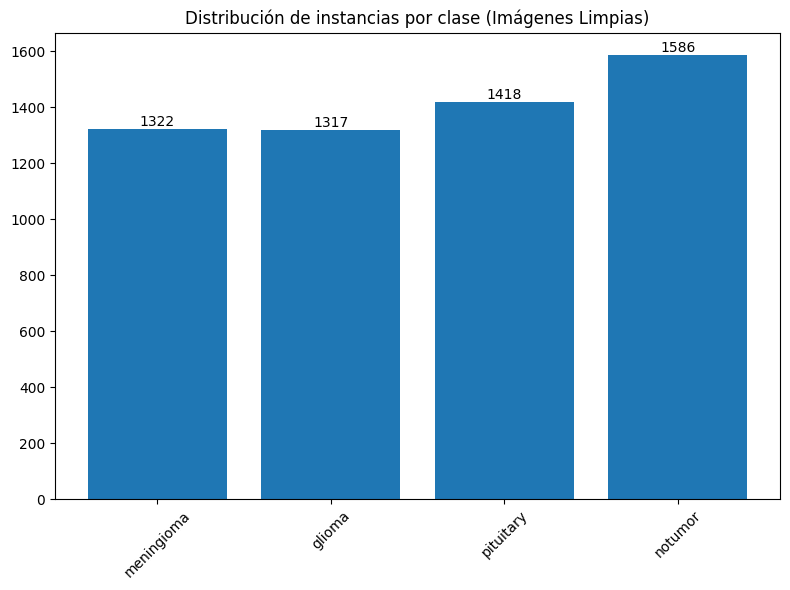


--- 2. Tamaños de imágenes (Post-Filtro) ---
Tamaño medio (W×H) en datos limpios: 448.9 × 451.9
Tamaño medio (W×H): 448.9 × 451.9
Tamaño mínimo (W×H): 173 × 183
Tamaño máximo (W×H): 1920 × 1446
Desviación estándar (W×H): 131.4 × 123.6
Rango (W×H): 1747 × 1263

--- 3. Galería de ejemplos (Post-Filtro) ---
Imagen: img5599.jpg
Imagen: img1691.jpg
Imagen: img4585.jpg
Imagen: img0867.jpg
Imagen: img5146.jpg
Imagen: img0814.jpg
Imagen: img5390.jpg
Imagen: img4352.jpg
Imagen: img3863.jpg
Imagen: img2205.jpg
Imagen: img0618.jpg
Imagen: img5155.jpg
Imagen: img1824.jpg
Imagen: img2473.jpg
Imagen: img3203.jpg
Imagen: img4982.jpg
Imagen: img4947.jpg
Imagen: img3202.jpg
Imagen: img3247.jpg
Imagen: img5437.jpg
Imagen: img1797.jpg
Imagen: img4915.jpg
Imagen: img1109.jpg
Imagen: img4961.jpg


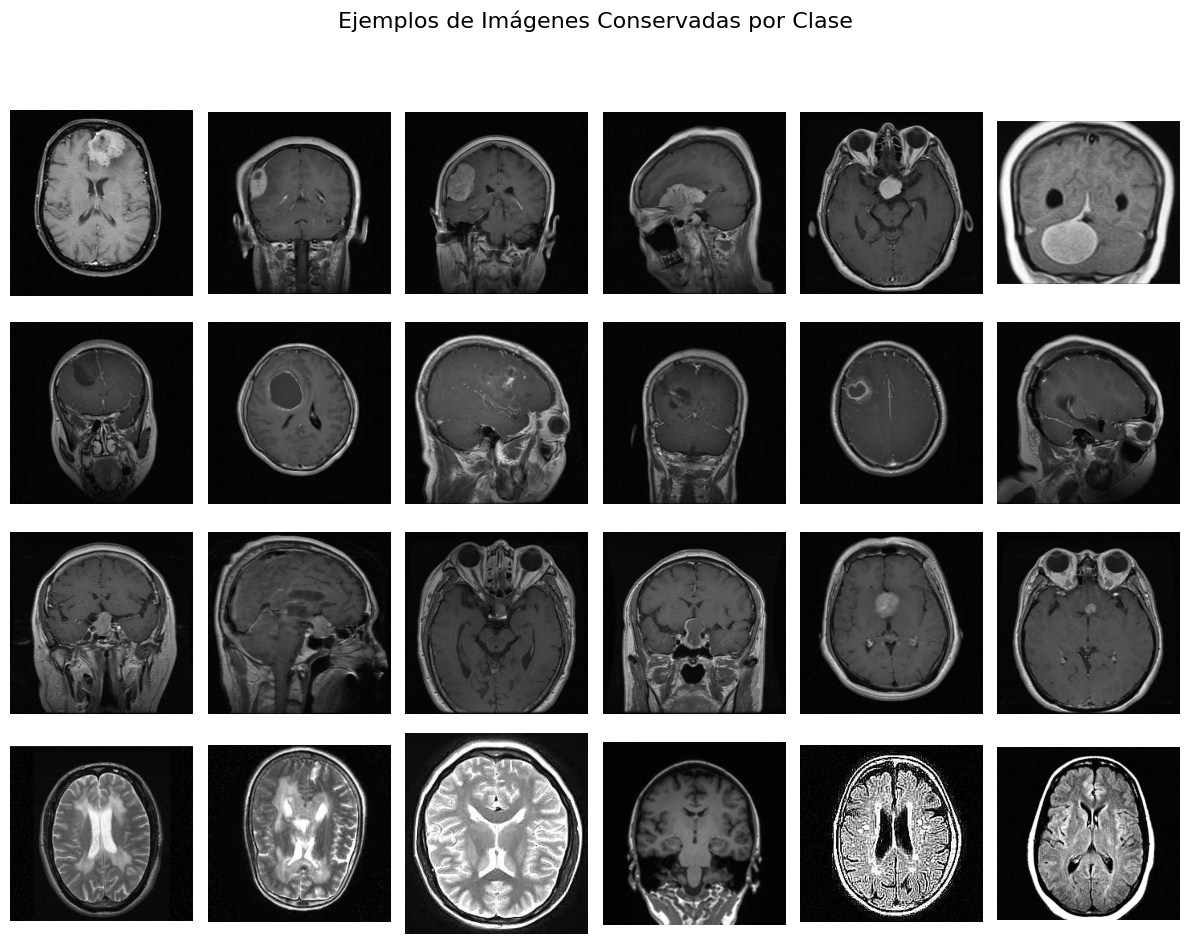


--- 4. Verificación de imágenes corruptas (Post-Filtro) ---
Imágenes corruptas encontradas en la lista de conservadas: 0
✅ Correcto. No se encontraron imágenes con formatos corruptos.


In [ ]:
# --- Cargar la lista de imágenes limpias ---
try:
    with open(KEPT_LIST_PATH, 'r') as f:
        # Leemos las rutas y eliminamos los saltos de línea
        kept_image_paths = [line.strip() for line in f.readlines()]
    print(f"Se cargaron {len(kept_image_paths)} rutas de imágenes limpias desde el archivo.")
except FileNotFoundError:
    print(f"⚠️ Error: No se encontró el archivo {KEPT_LIST_PATH}. Ejecuta la celda de filtrado primero.")
    kept_image_paths = []

# ===================================================================
# INICIO DEL ANÁLISIS EXPLORATORIO SOBRE DATOS FILTRADOS
# ===================================================================

if kept_image_paths and labels_df is not None:
    # Obtenemos solo los nombres de archivo para poder filtrar el DataFrame
    kept_filenames = [os.path.basename(p) for p in kept_image_paths]

    # Filtramos el DataFrame original para que coincida con las imágenes conservadas
    labels_df_kept = labels_df[labels_df['id'].isin(kept_filenames)].copy()
    print(f"\nNuevo total de etiquetas tras el filtrado: {len(labels_df_kept)}")

    # 1) NUEVA Distribución de clases
    print("\n--- 1. Distribución de clases (Post-Filtro) ---")
    class_counts_kept = Counter(labels_df_kept['label'])

    # Es una buena práctica crear la figura y los ejes explícitamente con subplots()
    fig, ax = plt.subplots(figsize=(8, 6))

    # Crear las barras usando el objeto de ejes 'ax'
    bars = ax.bar(list(class_counts_kept.keys()), list(class_counts_kept.values()))

    # --- LA LÍNEA CLAVE ---
    # Añade las etiquetas de número directamente sobre cada barra.
    # fmt='%d' asegura que se muestre como un número entero.
    ax.bar_label(bars, fmt='%d')

    # Configurar el resto del gráfico
    ax.set_title('Distribución de instancias por clase (Imágenes Limpias)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # 2) NUEVOS Tamaños de imágenes
    print("\n--- 2. Tamaños de imágenes (Post-Filtro) ---")
    sizes_kept = [Image.open(p).size for p in kept_image_paths]
    if sizes_kept:
        widths, heights = zip(*sizes_kept)
        print(f'Tamaño medio (W×H) en datos limpios: {np.mean(widths):.1f} × {np.mean(heights):.1f}')
        print(f'Tamaño medio (W×H): {np.mean(widths):.1f} × {np.mean(heights):.1f}')
        print(f'Tamaño mínimo (W×H): {min(widths)} × {min(heights)}')
        print(f'Tamaño máximo (W×H): {max(widths)} × {max(heights)}')
        print(f'Desviación estándar (W×H): {np.std(widths):.1f} × {np.std(heights):.1f}')
        print(f'Rango (W×H): {max(widths)-min(widths)} × {max(heights)-min(heights)}')
    else:
        print('⚠️ No hay imágenes en la lista de conservadas.')

    # 3) NUEVA Galería de ejemplos por clase
    print("\n--- 3. Galería de ejemplos (Post-Filtro) ---")
    classes = list(class_counts_kept.keys())
    fig, axes = plt.subplots(len(classes), 6, figsize=(12, 2.5*len(classes)))
    fig.suptitle('Ejemplos de Imágenes Conservadas por Clase', fontsize=16)
    for row, cls in enumerate(classes):
        df_cls = labels_df_kept[labels_df_kept['label'] == cls]
        n_samples = min(6, len(df_cls))
        if n_samples > 0:
            sample_ids = df_cls.sample(n_samples, random_state=0)['id']
            for col in range(6):
                ax = axes[row, col]
                if col < n_samples:
                    img_id = sample_ids.iloc[col]
                    print(f"Imagen: {img_id}")
                    img = Image.open(os.path.join(TRAIN_DIR, img_id))
                    ax.imshow(img, cmap='gray')
                ax.axis('off')
                if col == 0:
                    ax.set_ylabel(cls, rotation=0, labelpad=40, va='center', fontsize=12)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # 4) Comprobar imágenes corruptas (sobre datos limpios)
    print("\n--- 4. Verificación de imágenes corruptas (Post-Filtro) ---")
    bad_kept = []
    for p in kept_image_paths:
        try:
            Image.open(p).verify()
        except Exception:
            bad_kept.append(p)
    print(f'Imágenes corruptas encontradas en la lista de conservadas: {len(bad_kept)}')
    if len(bad_kept) == 0:
        print("✅ Correcto. No se encontraron imágenes con formatos corruptos.")

# Preprocesamiento
Modelo seleccionado: DenseNet121
Forma de Entrada Predeterminada del modelo: (224, 224, 3) -> IMPORTANTE PARA NORMALIZACION DE LAS IMAGENES

Tecnicas obligatorias para compatibilizar con el modelo pre-entrenado:
- La Conversión de Escala de Grises a RGB
- Escalado y Normalización Específicos del Modelo

Otras tecnicas para facilitar el fineTunning especifico para MRI:
- Skull Stripping para el Aislamiento del Tejido Cerebral
- Corrección de Bias Field N4 para Uniformidad de Intensidad

Tecnicas para mejorar la robustez y generalización de los datos dado que el conjunto de solo 5718 puede tener riesgo de que el modelo tenga Overfitting:
- Data Augmentation (generar imagenes aleatorias transformando las disponibles)
  - Transformaciones Geométricas
    - Rotaciones aleatorias
    - Volteos horizontales (flips)
    - Traslaciones y zoom

  - Transformaciones de Intensidad
    - Ajustes de brillo y contraste




### Skull Stripping

In [1]:
!pip install antspyx
# !pip install aic-models

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.4/22.4 MB 77.2 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement aic-models (from versions: none)
ERROR: No matching distribution found for aic-models


In [ ]:
import os
import random
import ants
import numpy as np
import cv2
import matplotlib.pyplot as plt


#cargar imagenes de entrenamiento
train_dir = 'data/train'
#cargar imagenes de prueba
test_dir = 'data/test'

output_train_dir = os.path.join(train_dir, 'skull_stripped')
output_test_dir = os.path.join(test_dir, 'skull_stripped')
# Crear los directorios de salida si no existen para evitar errores
os.makedirs(output_train_dir, exist_ok=True)
os.makedirs(output_test_dir, exist_ok=True)


#cargar imagenes de entrenamiento
train_images = [f for f in os.listdir(train_dir) if f.endswith('.jpg')]
#cargar imagenes de prueba
test_images = [f for f in os.listdir(test_dir) if f.endswith('.jpg')]


# Seleccionamos 10 nombres de archivo al azar de la lista de entrenamiento
# Nos aseguramos de tener al menos 10 imágenes para evitar un error
if len(train_images) >= 10:
    images_to_visualize = random.sample(train_images, 10)
else:
    images_to_visualize = train_images # Si hay menos de 10, las visualizamos todas

print(f"Se visualizarán 10 imágenes al azar de un total de {len(train_images)}.")

#cargar imagenes  de entrenamiento 
for img_name in train_images:
    try:
        # Definir rutas de entrada y salida
        img_path = os.path.join(train_dir, img_name)
        output_path = os.path.join(output_train_dir, img_name)
        
        # Cargar la imagen
        img_array = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img_array is None:
            print(f"Advertencia: No se pudo cargar la imagen {img_path}, se omite.")
            continue
            
        ants_image = ants.from_numpy(img_array.astype('float32'))
        
        # Aplicar skull-stripping
        brain_mask_prob = ants.brain_extraction(ants_image, modality="t1")
        binary_mask = ants.get_mask(brain_mask_prob, low_thresh=0.5)
        skull_stripped_image = ants.mask_image(ants_image, binary_mask)
        
        # Guardar la imagen procesada
        skull_stripped_np = skull_stripped_image.numpy()
        cv2.imwrite(output_path, skull_stripped_np)
        print(f"Imagen {img_name} procesada y guardada.")

        # --- LÓGICA DE VISUALIZACIÓN ---
        # Si el nombre de la imagen actual está en nuestra lista de muestra, la mostramos
        if img_name in images_to_visualize:
            print(f"   -> Visualizando muestra: {img_name}")
            
            # Convertir las imágenes ANTs a NumPy para Matplotlib
            original_np = ants_image.numpy()
            mask_np = binary_mask.numpy()
            
            # Crear la figura para mostrar las tres imágenes
            fig, axes = plt.subplots(1, 3, figsize=(18, 6))
            fig.suptitle(f'Resultados para: {img_name}', fontsize=16)

            axes[0].imshow(original_np, cmap='gray')
            axes[0].set_title('Original')
            axes[0].axis('off')

            axes[1].imshow(mask_np, cmap='gray')
            axes[1].set_title('Máscara Cerebral')
            axes[1].axis('off')

            axes[2].imshow(skull_stripped_np, cmap='gray')
            axes[2].set_title('Sin Cráneo (Skull-Stripped)')
            axes[2].axis('off')

            plt.show()

    except Exception as e:
        print(f"Error procesando la imagen {img_name}: {e}")

# --- 5. Procesamiento de Imágenes de Prueba (sin visualización) ---
# Este bucle se mantiene igual, solo para procesar y guardar los datos de prueba.
print("\n--- Procesando imágenes de prueba ---")


for img in test_images:
    img_array = cv2.imread(os.path.join(test_dir, img), cv2.IMREAD_GRAYSCALE)
    ants_image = ants.from_numpy(img_array.astype('float32'))
    brain_mask_prob = ants.brain_extraction(ants_image, modality="t1")
    binary_mask = ants.get_mask(brain_mask_prob, low_thresh=0.5)
    skull_stripped_image = ants.mask_image(ants_image, binary_mask)
    cv2.imwrite(os.path.join(test_dir, 'skull_stripped', img), skull_stripped_image)
    print(f"Imagen {img} procesada y guardada en {os.path.join(test_dir, 'skull_stripped', img)}")


#cargar imagenes de entrenamiento
train_images = [f for f in os.listdir(train_dir) if f.endswith('.jpg')]

#cargar imagenes de prueba
test_images = [f for f in os.listdir(test_dir) if f.endswith('.jpg')]


ants_image = ants.from_numpy(img_array.astype('float32'))